In [2]:
%pip install rocketpy
import numpy as np
import matplotlib.pyplot as plt
from rocketpy import Environment, SolidMotor, Rocket, Flight
import datetime

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Define Environment Conditions
# Create environment with standard atmospheric conditions
env = Environment(latitude=32.990254, longitude=-106.974998, elevation=1400)

# Set date for atmospheric conditions (Spaceport America)
tomorrow = datetime.date.today() + datetime.timedelta(days=1)
env.set_date((tomorrow.year, tomorrow.month, tomorrow.day, 12))

# Set atmospheric model
env.set_atmospheric_model(type="Forecast", file="GFS")

print("Environment conditions set:")
print(f"Location: Spaceport America (32.99°N, -106.97°W)")
print(f"Elevation: 1400 m")
print(f"Date: {tomorrow}")
print("Atmospheric model: GFS Forecast")


Environment conditions set:
Location: Spaceport America (32.99°N, -106.97°W)
Elevation: 1400 m
Date: 2025-10-08
Atmospheric model: GFS Forecast


Total impulse: 8870.0 N⋅s
Maximum thrust: 2800 N
Burn time: 6.0 seconds


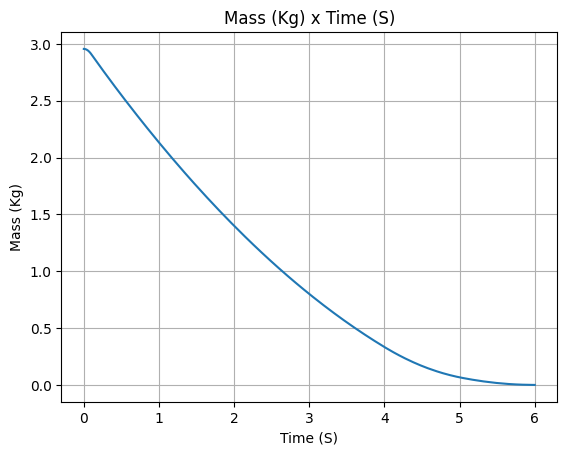

Propellant mass: Not calculated (using grain geometry)


In [8]:
# Create M Class Motor
# M class motors have total impulse between 5,120 and 10,240 N⋅s
# Using a typical M1378 motor specifications

# Create thrust curve data for M class motor
# Time points (seconds)
thrust_time = [0, 0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]
# Thrust values (Newtons) - typical M class profile
thrust_values = [0, 2800, 2600, 2400, 2200, 2000, 1800, 1600, 1400, 1200, 800, 400, 200, 0]

# Create the motor
motor = SolidMotor(
    thrust_source=list(zip(thrust_time, thrust_values)),
    dry_mass=15.0,  # kg - motor casing mass
    dry_inertia=(0.125, 0.125, 0.002),  # kg⋅m² - Inertia tensor (I11, I22, I33)
    burn_time=6.0,  # seconds
    grain_number=5,
    grain_separation=0.005,  # m - separation between grains
    grain_density=1815,  # kg/m³
    grain_outer_radius=0.033,  # m
    grain_initial_inner_radius=0.015,  # m
    grain_initial_height=0.12,  # m
    grains_center_of_mass_position=0.397,  # m - position of grains' center of mass
    center_of_dry_mass_position=0.317,  # m - position of dry mass center of mass
    nozzle_radius=0.033,  # m
    throat_radius=0.011,  # m
    nozzle_position=0,  # m - position of nozzle
    coordinate_system_orientation="nozzle_to_combustion_chamber",
    interpolation_method="linear"
)
print(f"Total impulse: {motor.total_impulse:.1f} N⋅s")
print(f"Maximum thrust: {max(thrust_values)} N")
# Handle burn_time which might be a tuple (start_time, end_time)
if isinstance(motor.burn_time, tuple):
    burn_duration = motor.burn_time[1] - motor.burn_time[0]
    print(f"Burn time: {burn_duration:.1f} seconds")
else:
    print(f"Burn time: {motor.burn_time:.1f} seconds")

# Check what propellant mass methods/properties are available
propellant_mass = getattr(motor, 'propellant_mass', None)
if callable(propellant_mass):
    mass_value = propellant_mass()
    if mass_value is not None:
        print(f"Propellant mass: {mass_value:.1f} kg")
    else:
        print("Propellant mass: Not calculated (using grain geometry)")
elif propellant_mass is not None:
    print(f"Propellant mass: {propellant_mass:.1f} kg")
else:
    # Calculate propellant mass from grain geometry
    grain_volume = (motor.grain_outer_radius**2 - motor.grain_initial_inner_radius**2) * np.pi * motor.grain_initial_height
    total_propellant_mass = grain_volume * motor.grain_density * motor.grain_number
    print(f"Propellant mass (calculated): {total_propellant_mass:.1f} kg")


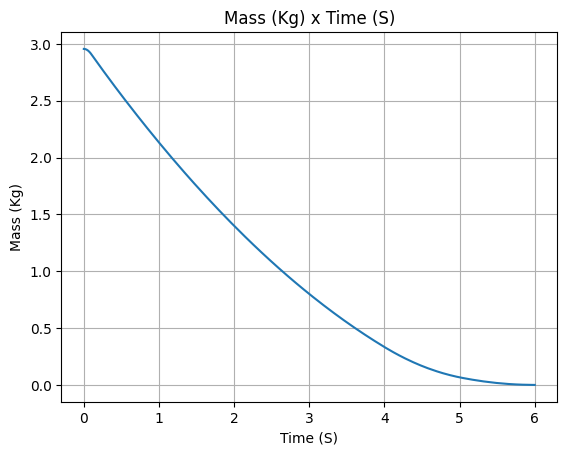

Rocket radius: 0.0635 m
Rocket dry mass: 50.0 kg
Total mass with propellant: 53.0 kg
Motor position: -1.255 m from nose tip


In [15]:
# Define Rocket Geometry and Mass Properties
# Create the rocket structure

rocket = Rocket(
    radius=0.0635,  # m (2.5 inches radius, 5 inch diameter)
    mass=50.0,      # kg - dry mass without motor
    inertia=(6.321, 6.321, 0.0346),  # kg⋅m² (Ixx, Iyy, Izz)
    power_off_drag=0.5,  # Drag coefficient when motor is off
    power_on_drag=0.6,   # Drag coefficient when motor is on
    center_of_mass_without_motor=1.317,  # m from nose tip
    coordinate_system_orientation="nose_to_tail"
)

# Add the motor to the rocket
rocket.add_motor(motor, position=-1.255)  # m from nose tip (motor at tail)

# Calculate propellant mass for total mass calculation
propellant_mass = getattr(motor, 'propellant_mass', None)
if callable(propellant_mass):
    mass_value = propellant_mass()
    if mass_value is not None:
        prop_mass = mass_value
    else:
        # Calculate from grain geometry
        grain_volume = (motor.grain_outer_radius**2 - motor.grain_initial_inner_radius**2) * np.pi * motor.grain_initial_height
        prop_mass = grain_volume * motor.grain_density * motor.grain_number
elif propellant_mass is not None:
    prop_mass = propellant_mass
else:
    # Calculate from grain geometry
    grain_volume = (motor.grain_outer_radius**2 - motor.grain_initial_inner_radius**2) * np.pi * motor.grain_initial_height
    prop_mass = grain_volume * motor.grain_density * motor.grain_number


print(f"Rocket radius: {rocket.radius} m")
print(f"Rocket dry mass: {rocket.mass} kg")
print(f"Total mass with propellant: {rocket.mass + prop_mass:.1f} kg")
print(f"Motor position: -1.255 m from nose tip")


In [ ]:
# Add Nose Cone and Fins
# Add nose cone
nose_cone = rocket.add_nose(length=0.55, kind="vonKarman", position=1.278)

# Add trapezoidal fins (without airfoil file - will use default)
fin_set = rocket.add_trapezoidal_fins(
    n=4,                    # Number of fins
    root_chord=0.120,       # m - Root chord length
    tip_chord=0.060,        # m - Tip chord length  
    span=0.110,             # m - Fin span
    position=-1.04956,      # m - Position from nose tip
    cant_angle=0.5          # degrees - Cant angle
    # airfoil parameter removed - will use default airfoil
)

print(f"Nose cone: von Karman, length = 0.55 m")
print(f"Fins: 4 trapezoidal fins")
print(f"Fin root chord: 0.120 m")
print(f"Fin tip chord: 0.060 m") 
print(f"Fin span: 0.110 m")
print("Using default airfoil profile")


Nose cone: von Karman, length = 0.55 m
Fins: 4 trapezoidal fins
Fin root chord: 0.120 m
Fin tip chord: 0.060 m
Fin span: 0.110 m
Using default airfoil profile


In [13]:
# Add Recovery System (Parachutes)
# Add drogue parachute for initial descent
drogue = rocket.add_parachute(
    name="drogue",
    cd_s=1.0,              # m² - Drag coefficient × Reference area
    trigger=800,           # m - Deploy at 800m AGL
    sampling_rate=105,     # Hz
    lag=1.5,              # s - Deployment lag
    noise=(0, 8.3, 0.5)   # Noise parameters
)

# Add main parachute for final descent
main = rocket.add_parachute(
    name="main",
    cd_s=10.0,            # m² - Larger chute for slower descent
    trigger=300,          # m - Deploy at 300m AGL  
    sampling_rate=105,    # Hz
    lag=1.5,             # s - Deployment lag
    noise=(0, 8.3, 0.5)  # Noise parameters
)

print(f"Drogue parachute: Cd×S = 1.0 m², deploys at 800m AGL")
print(f"Main parachute: Cd×S = 10.0 m², deploys at 300m AGL")
print("Dual-deploy recovery system configured")


Drogue parachute: Cd×S = 1.0 m², deploys at 800m AGL
Main parachute: Cd×S = 10.0 m², deploys at 300m AGL
Dual-deploy recovery system configured


In [17]:
# Run Flight Simulation
# Create and run the flight simulation
flight = Flight(
    rocket=rocket,
    environment=env,
    rail_length=5.2,
    inclination=85,
    heading=0,
    initial_solution=None
)

print(f"Launch rail length: {flight.rail_length} m")
print(f"Launch inclination: {flight.inclination}°")
print(f"Launch heading: {flight.heading}°")


Launch rail length: 5.2 m
Launch inclination: 85°
Launch heading: 0°


In [20]:
# Display Key Flight Results
# Print important flight statistics
print("FLIGHT SIMULATION RESULTS")
print(f"Maximum altitude: {flight.apogee:.1f} m ({flight.apogee*3.28084:.1f} ft)")
print(f"Maximum Mach number: {flight.max_mach_number:.2f} Mach")
print(f"Maximum speed: {flight.max_speed:.1f} m/s")
print(f"Maximum acceleration: {flight.max_acceleration:.1f} m/s² ({flight.max_acceleration/9.81:.1f} g)")
print(f"Apogee time: {flight.apogee_time:.1f} seconds")
print(f"Flight time: {flight.t_final:.1f} seconds")
print(f"Impact velocity: {abs(flight.impact_velocity):.1f} m/s")
print(f"Lateral distance: {(flight.x_impact**2 + flight.y_impact**2)**0.5:.1f} m")
print("--------------------------------")
print("MOTOR PERFORMANCE")
print(f"Total impulse: {motor.total_impulse:.1f} N⋅s")
print(f"Average thrust: {motor.average_thrust:.1f} N")
print(f"Maximum thrust: {motor.max_thrust:.1f} N")
# Handle burn_time which might be a tuple (start_time, end_time)
if isinstance(motor.burn_time, tuple):
    burn_duration = motor.burn_time[1] - motor.burn_time[0]
    print(f"Burn time: {burn_duration:.1f} seconds")
    print(f"Burn time range: {motor.burn_time[0]:.1f} - {motor.burn_time[1]:.1f} seconds")
else:
    print(f"Burn time: {motor.burn_time:.1f} seconds")


FLIGHT SIMULATION RESULTS
Maximum altitude: 2080.7 m (6826.4 ft)
Maximum Mach number: 0.32 Mach
Maximum speed: 111.4 m/s
Maximum acceleration: 31.5 m/s² (3.2 g)
Apogee time: 13.4 seconds
Flight time: 24.5 seconds
Impact velocity: 110.9 m/s
Lateral distance: 243.5 m
--------------------------------
MOTOR PERFORMANCE
Total impulse: 8870.0 N⋅s
Average thrust: 1478.3 N
Maximum thrust: 2800.0 N
Burn time: 6.0 seconds
Burn time range: 0.0 - 6.0 seconds


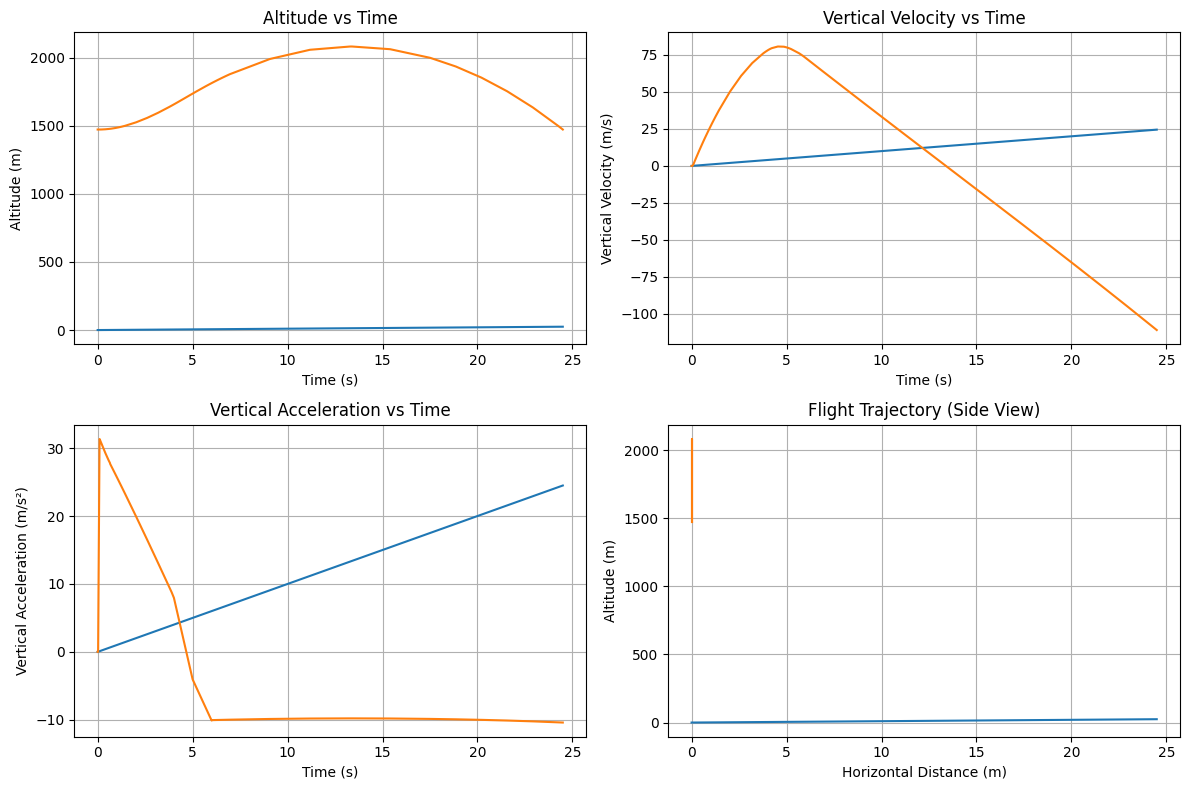

In [21]:
# Plot Flight Trajectory
# Create altitude vs time plot
plt.figure(figsize=(12, 8))

# Subplot 1: Altitude vs Time
plt.subplot(2, 2, 1)
plt.plot(flight.time, flight.z)
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.title('Altitude vs Time')
plt.grid(True)

# Subplot 2: Velocity vs Time  
plt.subplot(2, 2, 2)
plt.plot(flight.time, flight.vz)
plt.xlabel('Time (s)')
plt.ylabel('Vertical Velocity (m/s)')
plt.title('Vertical Velocity vs Time')
plt.grid(True)

# Subplot 3: Acceleration vs Time
plt.subplot(2, 2, 3)
plt.plot(flight.time, flight.az)
plt.xlabel('Time (s)')
plt.ylabel('Vertical Acceleration (m/s²)')
plt.title('Vertical Acceleration vs Time')
plt.grid(True)

# Subplot 4: Flight Path (2D trajectory)
plt.subplot(2, 2, 4)
plt.plot(flight.x, flight.z)
plt.xlabel('Horizontal Distance (m)')
plt.ylabel('Altitude (m)')
plt.title('Flight Trajectory (Side View)')
plt.grid(True)

plt.tight_layout()
plt.show()


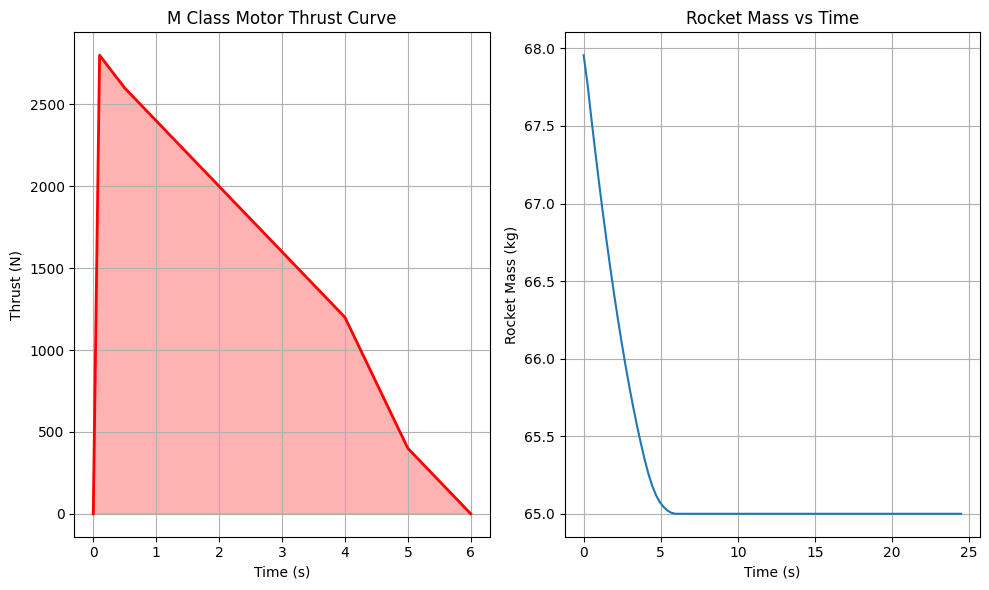

In [22]:
# Plot Motor Thrust Curve
plt.figure(figsize=(10, 6))

# Plot thrust vs time
plt.subplot(1, 2, 1)
plt.plot(thrust_time, thrust_values, 'r-', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Thrust (N)')
plt.title('M Class Motor Thrust Curve')
plt.grid(True)
plt.fill_between(thrust_time, thrust_values, alpha=0.3, color='red')

# Plot mass vs time during flight
plt.subplot(1, 2, 2)
# Create time array for mass calculation
time_array = np.linspace(0, flight.t_final, 100)
mass_array = [flight.rocket.total_mass(t) for t in time_array]
plt.plot(time_array, mass_array)
plt.xlabel('Time (s)')
plt.ylabel('Rocket Mass (kg)')
plt.title('Rocket Mass vs Time')
plt.grid(True)

plt.tight_layout()
plt.show()
